In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os,copy,pickle
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)


/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
# test data는 컬럼수가 20개임( train data 는 21개) ==> target data 1개가 적음
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [5]:
#train_data 카피
train_copy = copy.deepcopy(train) 

In [6]:
# train data에서, target data 인 'price' 분리해서, y 에 저장 
y = train['price']

#train data에서 'price' 삭제, test data 와 컬럼수 동일해짐
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# feature engineering 및 전처리등 위해, 일시적으로  데이터 결합
train_len = len(train)

data = pd.concat((train, test), axis=0, ignore_index = True)
print(data.head(3),data.tail(3))

   id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3        1.0         1180      5650     1.0   
1   1  20150225T000000         2        1.0          770     10000     1.0   
2   2  20150218T000000         3        2.0         1680      8080     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503             id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
21500  21

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_l

In [9]:
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,10751.000000,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,6207.525755,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5375.500000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,10751.000000,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,16126.500000,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,21502.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### id, date 등 변수 정리
id 변수등은 모델이 집값을 예측하는데 도움을 주지 않을 것으로 판단되어 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [10]:
# 학습에 필요없는 'id' 삭제
del data['id']

# date 를 년월까지만 사용
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
print(data.shape)
print(data.head(3),data.tail())

(21503, 19)
     date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3        1.0         1180      5650     1.0           0   
1  201502         2        1.0          770     10000     1.0           0   
2  201502         3        2.0         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503            date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
21498  201406         3       1.75         15

## 2. Feature Rngineering 및 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

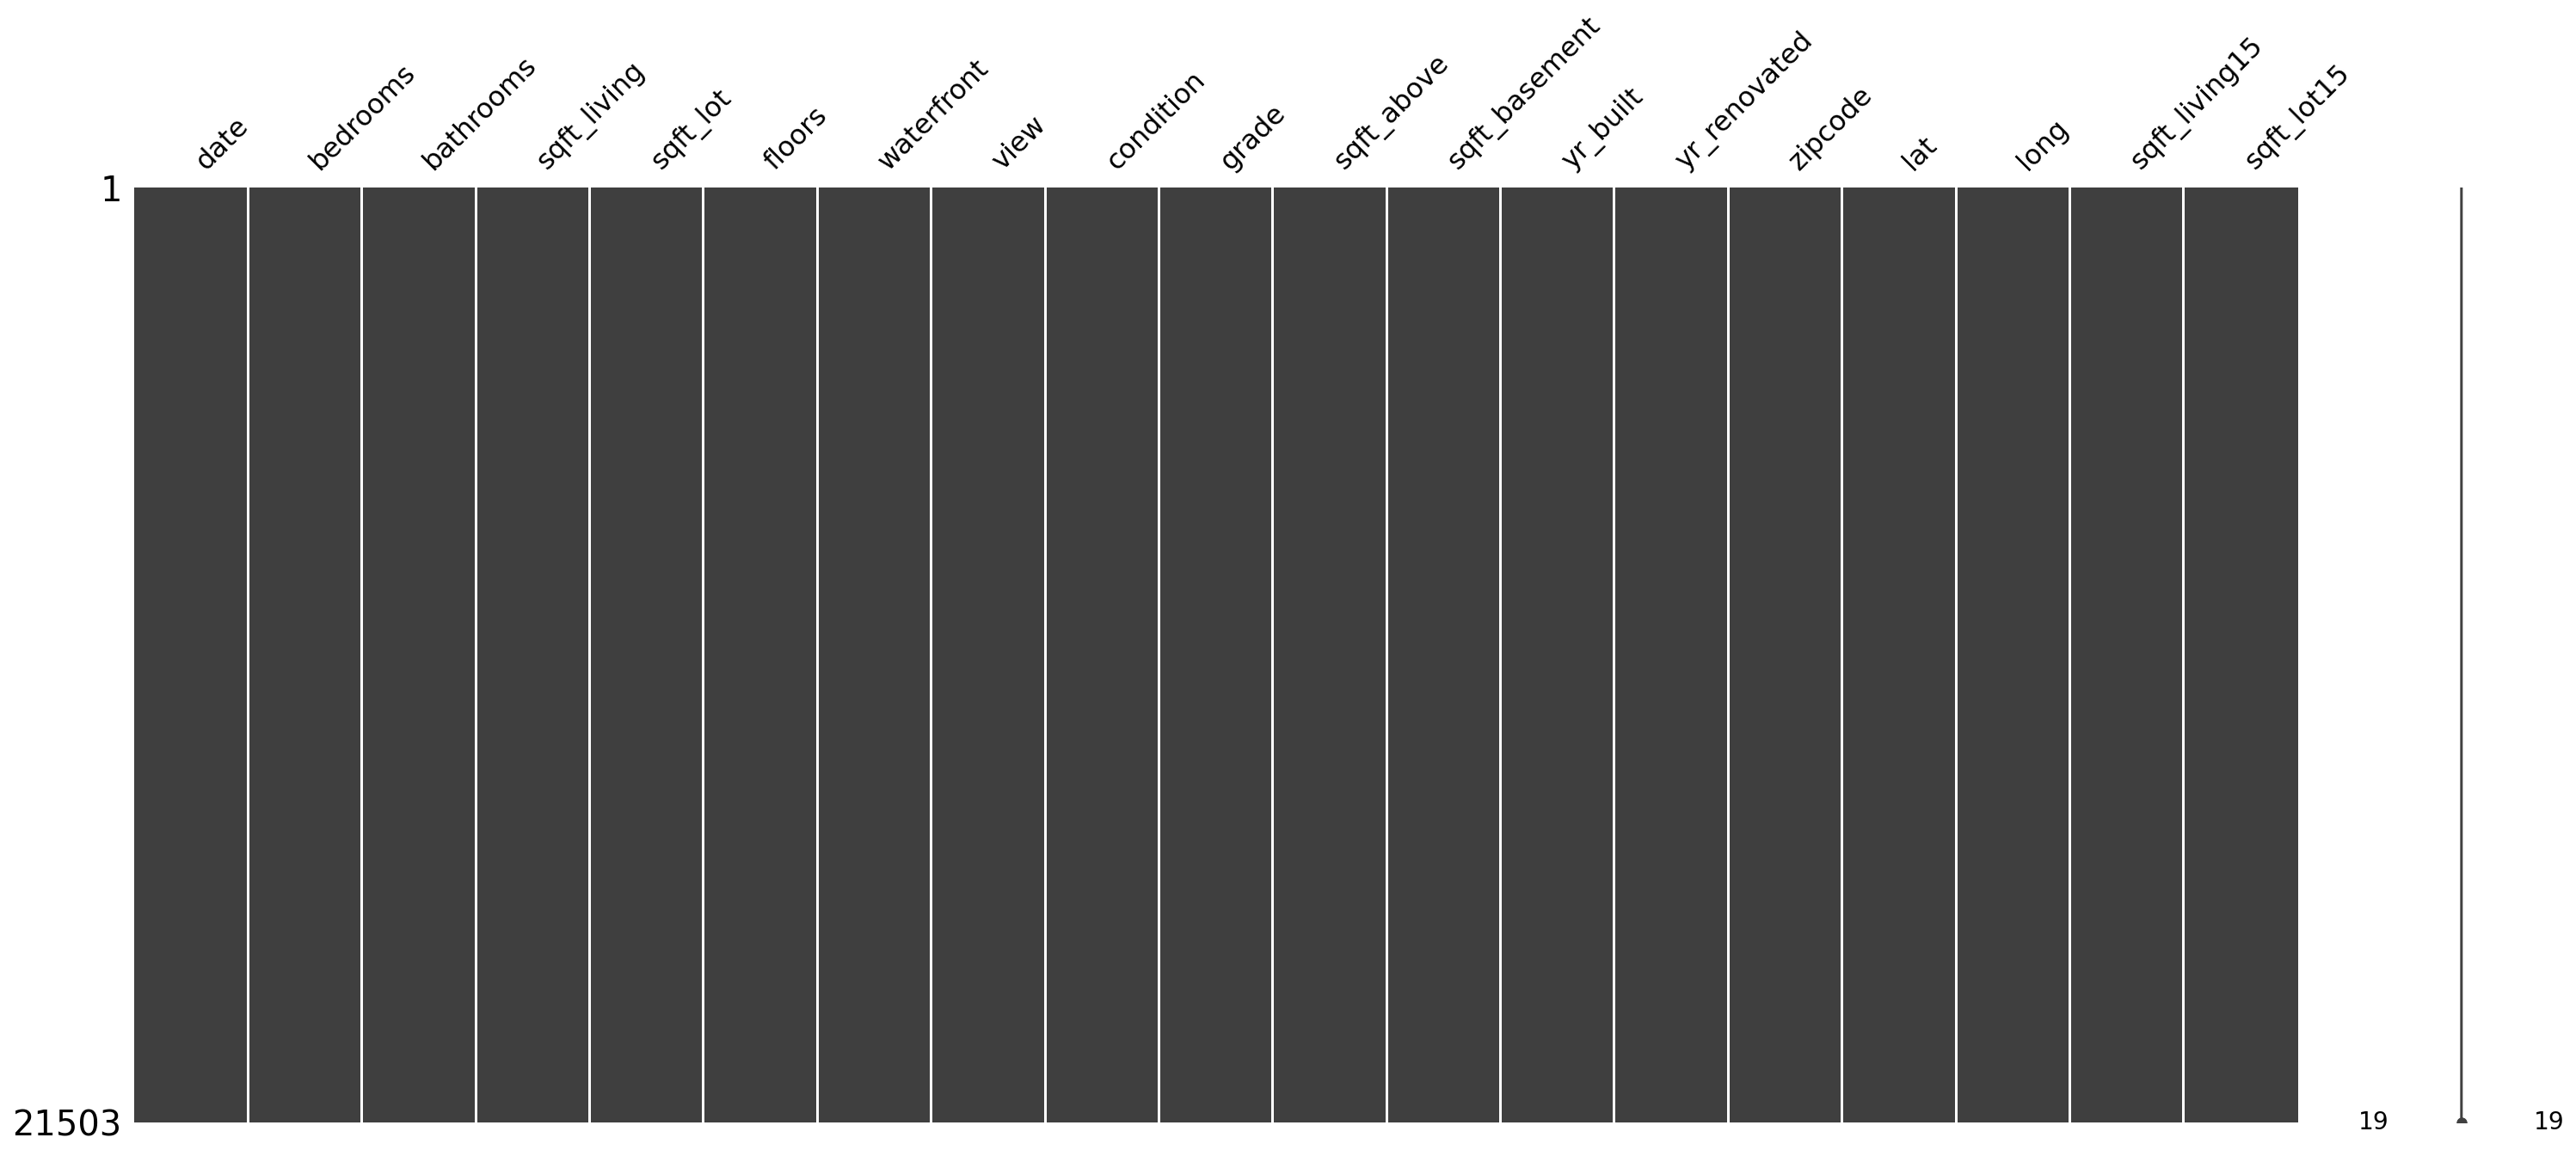

In [11]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [12]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 각변수들의 상관관계체크

<AxesSubplot:>

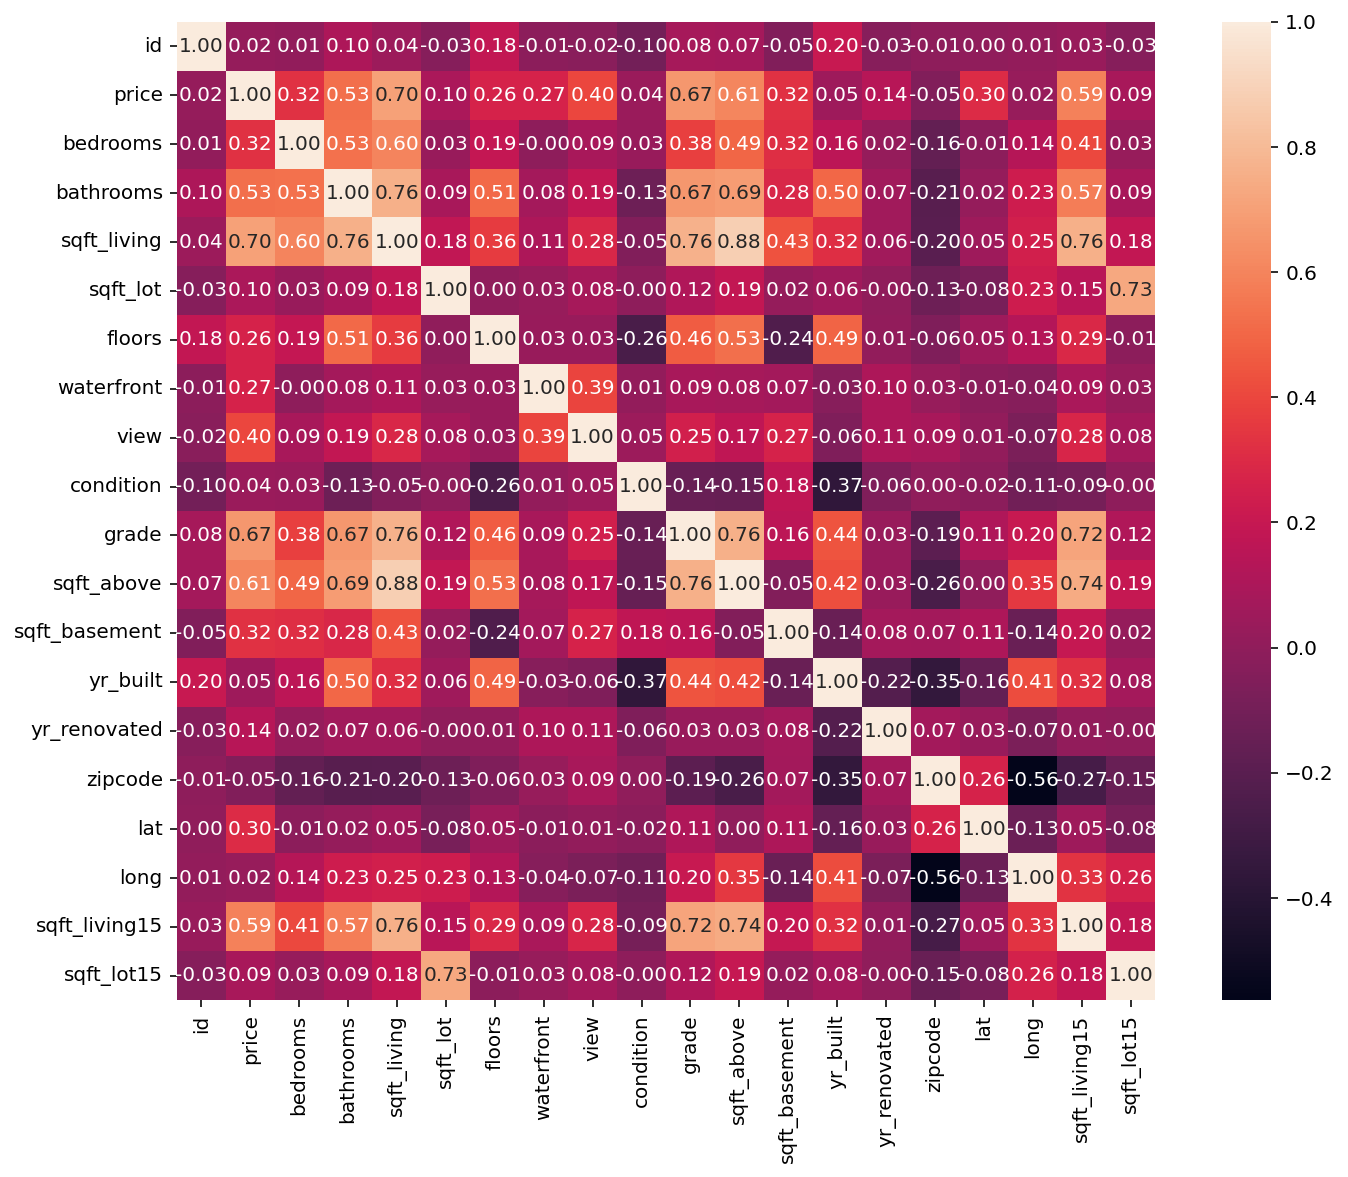

In [13]:
corr_mat = train_copy.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_mat, annot = True, fmt = '.2f', vmax = 1, square =True)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

columns: Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object') 19
data.index.duplicated().sum() 0


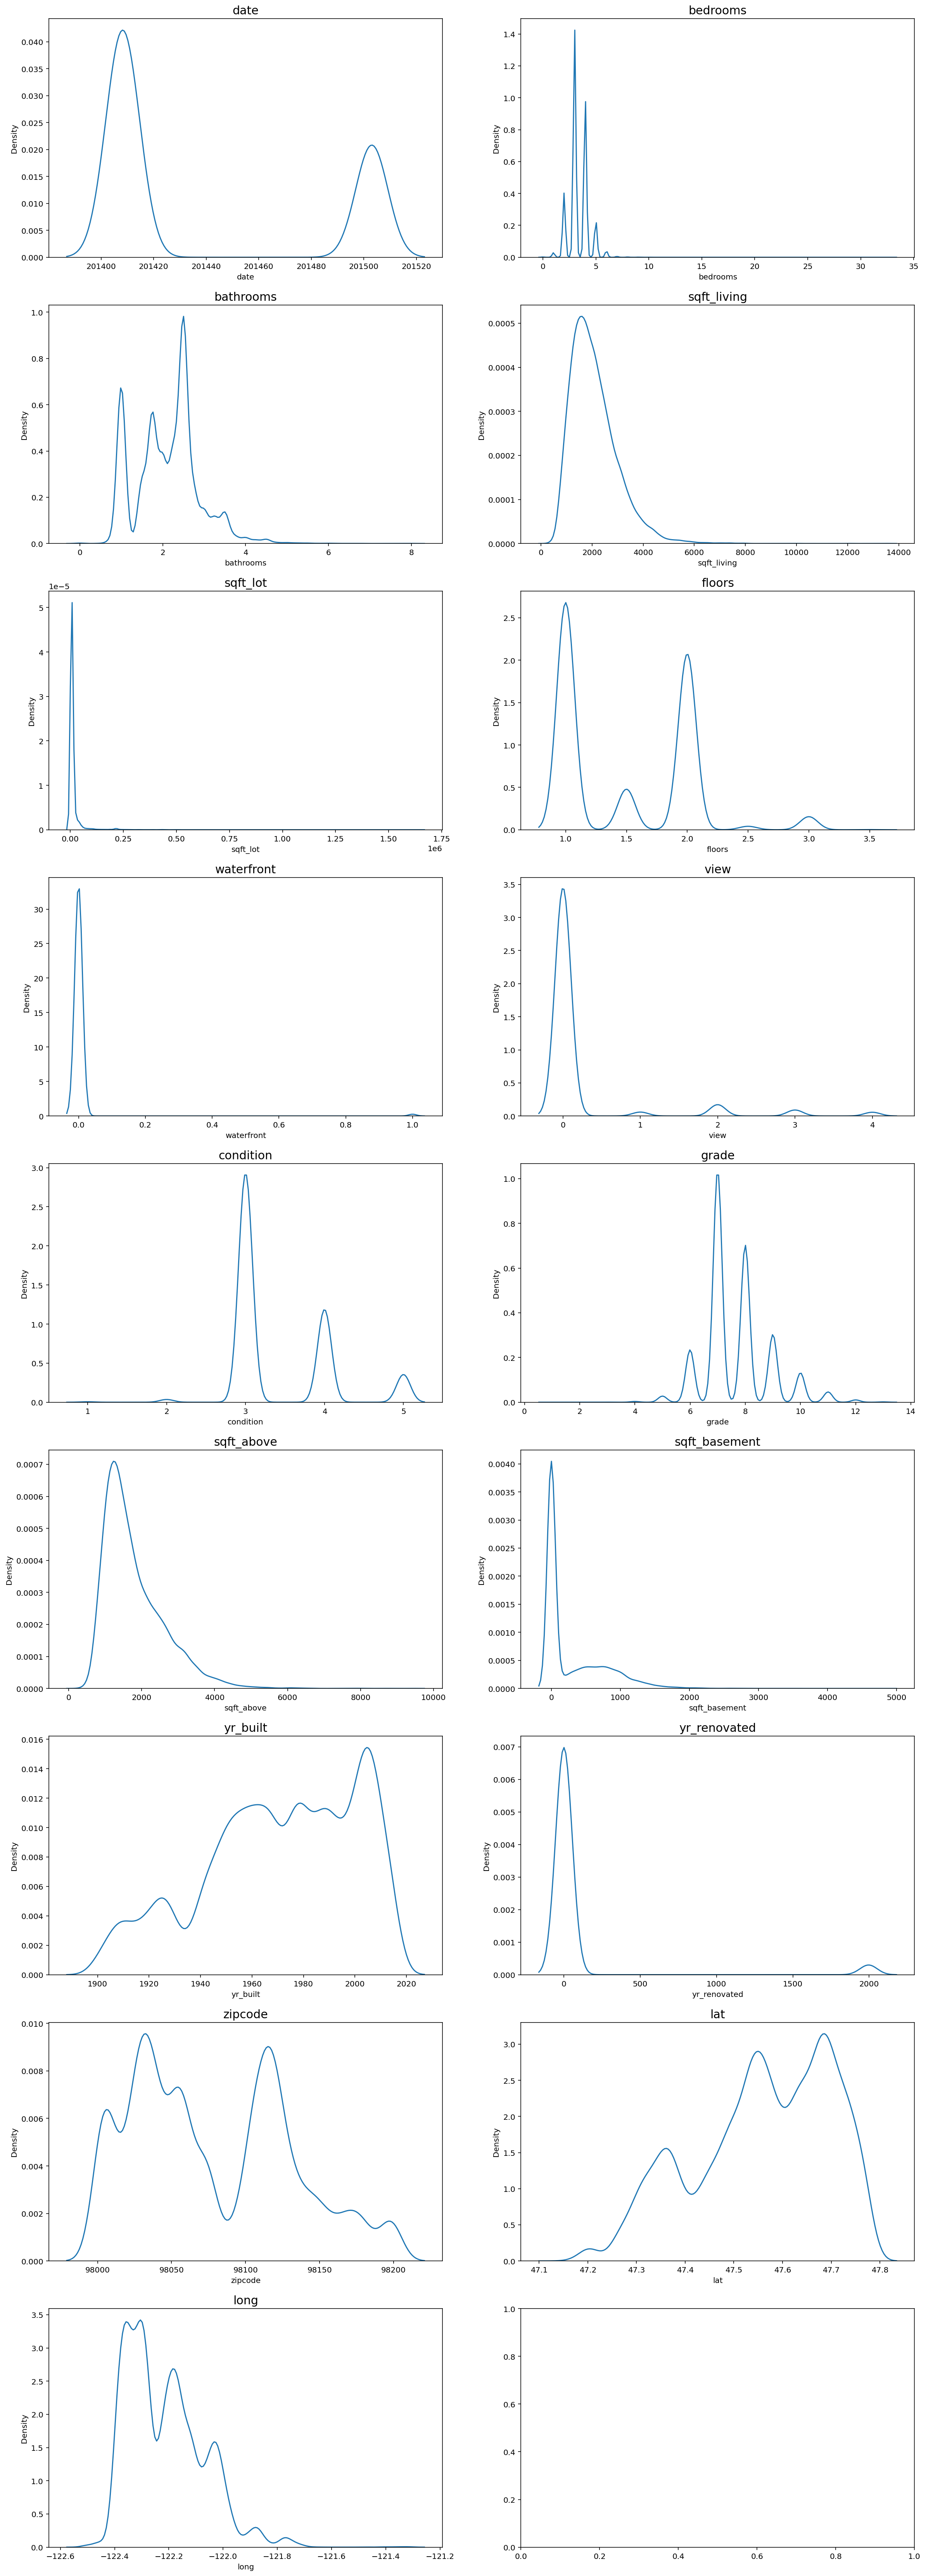

In [14]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
print('columns:', columns, len(columns))
print("data.index.duplicated().sum()",data.index.duplicated().sum())
for row in range(9):
    for col in range(2):
        #print('row',row, 'col',col,columns[count], data[columns[count]])
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 17 :
            break         

[0, 1]


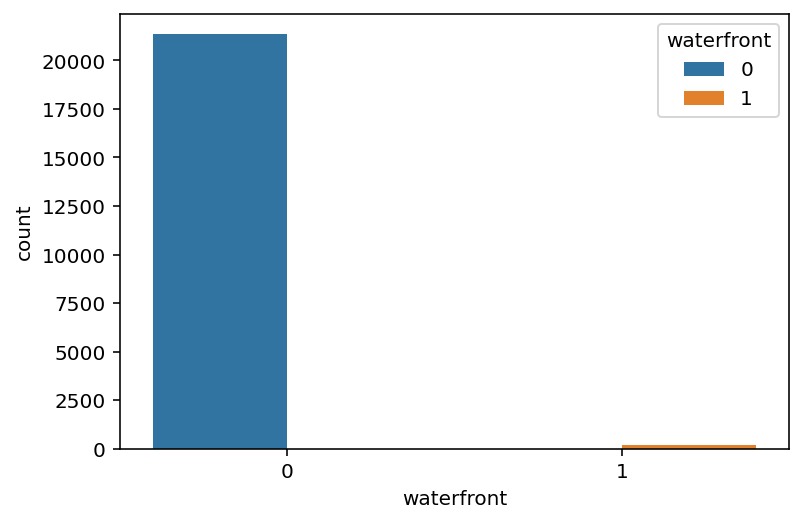

70
8689


In [15]:
# 'waterfront' 체크: 두개밖에 없어서, 분포가 치우침 
print(list(set(data['waterfront'])))
sns.countplot(data=data,x = 'waterfront', hue= 'waterfront')
plt.show()
# yr_renovated 체크: log scaling해도 변함없슴
print(len(list(set(data['yr_renovated']))))
# sqft_lot15 체크: log scaling해도 변함없슴
print(len(list(set(data['sqft_lot15']))))


In [16]:
# 범주형데이터 One-hot encoder
#data = pd.get_dummies(data, columns = ['yr_built', 'waterfront', 'zipcode'])

bedrooms, sqft_lot, sqft_basement 의 3개변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [17]:
skew_columns = ['bedrooms', 'sqft_lot','sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

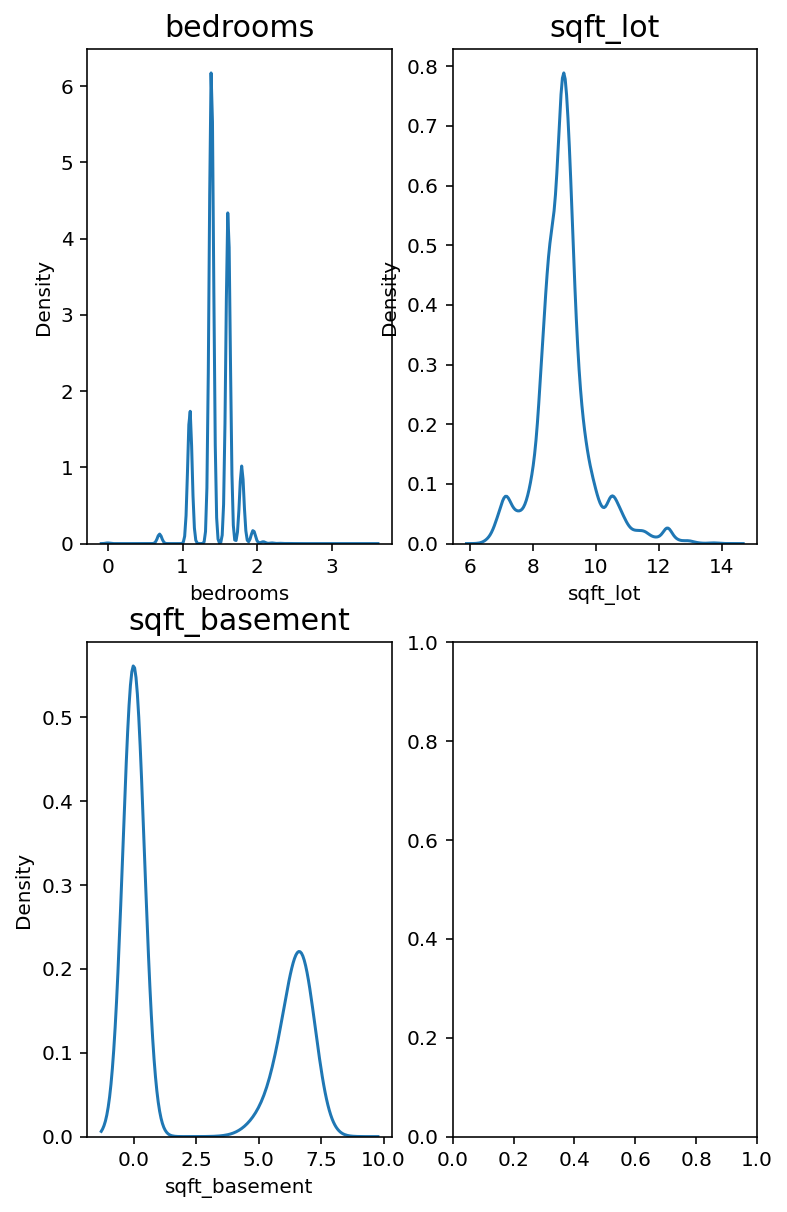

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(6, 10))

count = 0
for row in range(2):
    for col in range(2):
        if count == 3:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

#### Outlier 제거여부

상기에서 data,describe()의 기술통계량중 각 feature들의 표준편차가 3분위(75%)를 넘는 
feature가 없는 것으로 보아,이상치는 없는 것으로 보임

In [19]:
### Outlier제거
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
#oulier_idx = get_outlier(df=df, column='A', weight=1.5)
#df.drop(outlier_idx, axis=0, inplace=True)

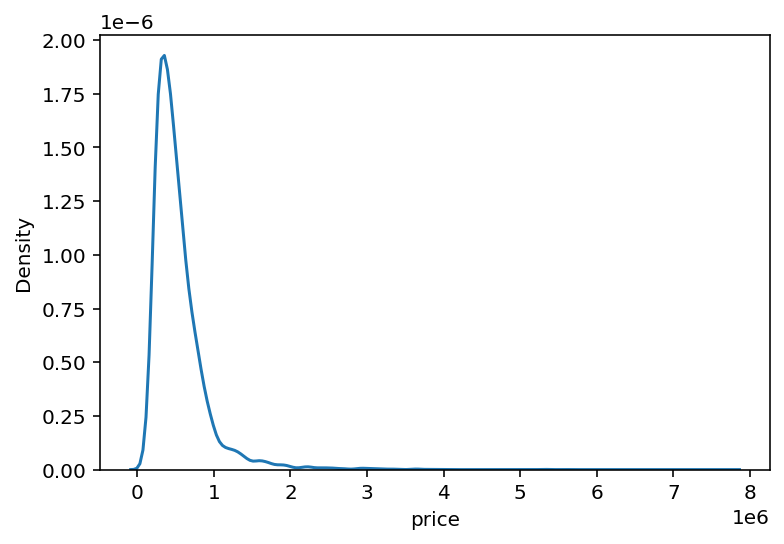

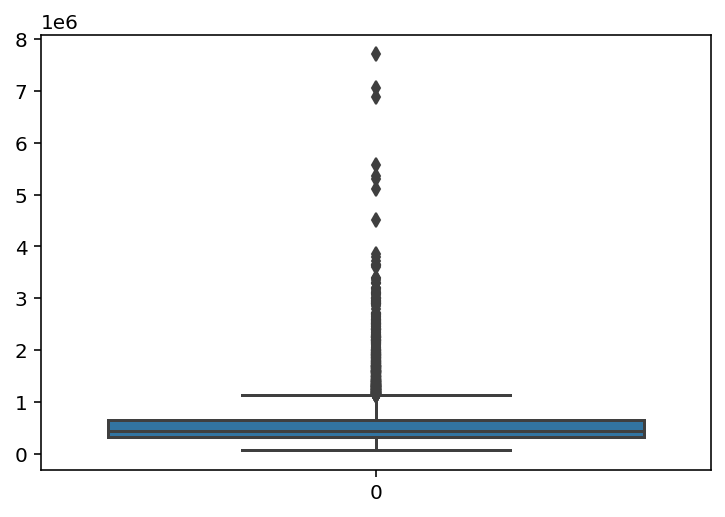

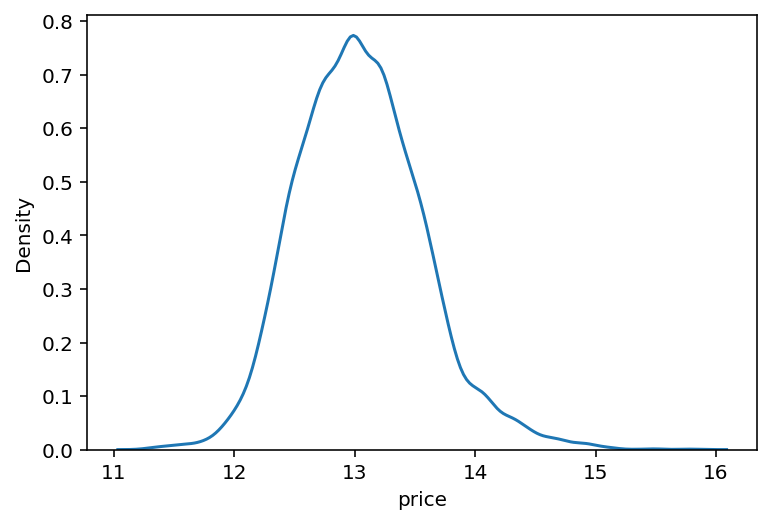

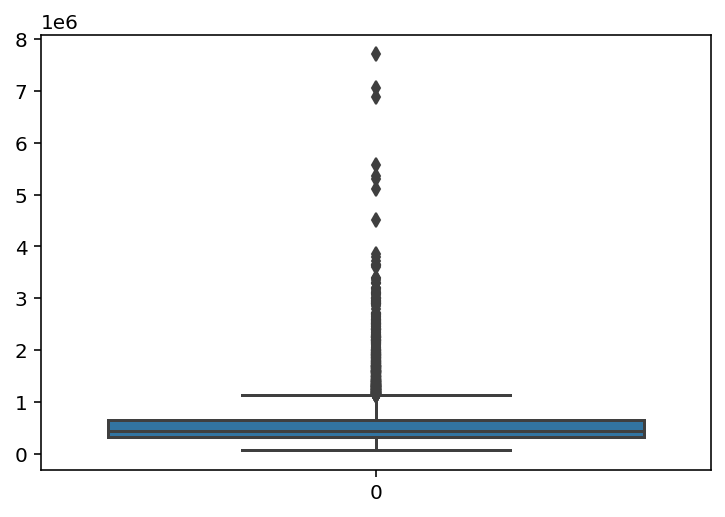

In [20]:
# target data 분포: skewed
sns.kdeplot(y)
plt.show()

sns.boxplot(data = y)
plt.show()

# 로그취해서 정규분포화
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

sns.boxplot(data = y)
plt.show()

### x_train, y_train, 및 x_test : y_train은 log scaling함

In [21]:
# train ,test data
x_train = data.iloc[:train_len, :]
y_train = y_log_transformation
x_test = data.iloc[train_len:, :]

print("x_train.shape",x_train.shape,"y_train.shape",y_train.shape,
      "x_test.shape",x_test.shape)

x_train.shape (15035, 19) y_train.shape (15035,) x_test.shape (6468, 19)


#### 데이터 정규화

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler =  StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [23]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
random_state=2020    

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models_baseline = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

#!models = [gboost, xgboost, lightgbm, rdforest]


### Baseline 모델 Cross Validation
Baseline 모델 교차 검증을 통해 Baseline 모델의 성능을 간단히 평가하겠습니다.

In [24]:
def get_cv_score(models_baseline):
    kfold = KFold(n_splits=5).get_n_splits(x_train)
    for m in models_baseline:
        print("Model {} CV score : {:.4f}".format(
            m['name'], np.mean(cross_val_score(m['model'], x_train, y_train)), 
                                             kf=kfold))
                                          

In [25]:
get_cv_score(models_baseline)

Model GradientBoosting CV score : 0.8797
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025


###   Baseline 모델 학습,예측 및 평가 : valid data 

In [26]:
def rmse(y_valid, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_valid), np.expm1(y_pred)))


In [27]:
def get_scores(models, x_train, y_train):
    df = {}
    #for model in models:    
    for m in models_baseline: 
        #model_name = model.__class__.__name__
        model_name = m['name']
        model = m['model']
        X_train1, X_valid1, y_train1, y_valid1 = train_test_split(x_train, y_train, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train1, y_train1)    
        # 예측
        y_pred1 = model.predict(X_valid1)
        print('y_pred1',y_pred1, y_pred1.shape)
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_valid1, y_pred1)    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

get_scores(models_baseline, x_train, y_train)

y_pred1 [13.24186351 12.08077918 12.55918752 ... 13.15124101 12.33385892
 13.26029005] (3007,)
y_pred1 [13.216568 12.09696  12.574539 ... 13.217966 12.285659 13.307217] (3007,)
y_pred1 [13.31590843 12.03589464 12.53084732 ... 13.20754098 12.3551064
 13.13206745] (3007,)


,RMSE
GradientBoosting,128359.651487
LightGBM,110869.040831
XGBoost,110551.388998


### Best 모델 하이퍼 파라미터 튜닝: 그리드 탐색

In [28]:
model = LGBMRegressor(random_state=random_state)
#model = XGBRegressor(random_state=random_state)

In [29]:
param_grid = {
    'n_estimators': [100], #[50, 100],
    'max_depth': [10], #[1, 10],
    #'learning_rate': [0.3, 0.2,0.1,0.05,0.03], 
    #'boosting': ['rf','gbdt','dart','goss'],
}

In [30]:
def my_GridSearch(model, x_train, y_train, param_grid, verbose=2, n_jobs=5):
    
    grid_model = GridSearchCV(model,param_grid=param_grid,\
                 scoring='neg_mean_squared_error',cv=5,verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(x_train,y_train)

    params = grid_model.cv_results_['params'] 
    score = grid_model.cv_results_['mean_test_score']
    rmsle = np.sqrt(-1*score)

    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = rmsle

    results = results.sort_values(by= 'RMSLE',ascending = True)
    best_rmsle = round(results['RMSLE'].min(),4)
    print(results)
    
    return results,best_rmsle

results, best_rmsle = my_GridSearch(model, x_train, y_train, param_grid, verbose=2, n_jobs=5)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
   max_depth  n_estimators     score     RMSLE
0         10           100 -0.027066  0.164516


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [31]:
def save_submission(x_train, y_train, x_test, rmsle = None):
    model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
    model_name = model.__class__.__name__
    
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    prediction = np.expm1(prediction)

    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
   
    submission['price'] = prediction
    #print(submission.head(),submission.shape)
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(
                             data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    return 

In [32]:
save_submission(x_train, y_train, x_test, rmsle = best_rmsle)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_RMSLE_0.1645.csv saved!
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.4s


#### 캐글 116049 점

## 회고

본 프로젝트는 캐글의 House price 예측문제로서,캐글에서 데이터셑을 받아서,작업진행하였습니다.

data.info()와 describe()를 통해 21개의 특성을 가진 데이터를 개략적으로 이해하고서,
21개컬럼 중 skewed된 분포를 갖은 bedrooms, sqft_lot, sqft_basement 의 3개변수와 target data를 
log-scaling을 통해 정규분포에 가깝게 만들었습니다.

결측치는 없었으며, 이상치는 describe()상 표준편차가 3분위 75%를 크게 넘어선 것이 없어서,생략했습니다

그후 train data와 test data를 standardscaler로 정규화시켰고, Baseline model로 1차 교차검증을 해보고,
다시 3개모델을 통해서, train data를 학습데이터및 valid data로 나누어 학습시킨후 모델성능 검증을
재차해보고서, 그중 속도도 빠르고, 우수하다고 판단되는 lightgbm 모델을 통해,gridsearch로
learning rate, max-depth, n-estimator 등의 튜닝을 시도했으나, 성능개선은 크지 않았습니다.

test data로 에측을 하고서, submission file에 담아, 캐글에 제출했으며, 캐글 점수는
116049 로 110000점이하에는 미달되었습니다,

여러 과목 수업진도와 프로젝트들을 시간내에 소화하려고 쫒기듯이 작업을 하게 되어 110000점이하로 못내려서 아쉬운 점은 있으나,데이터분석의 작업순서를 거쳐 난생처음 말로만 듣던 캐글까지 경험해본 것으로, 큰의미와 감사함을 느끼며, 나중에 숙련되고 시간이 될때 자주 캐글에도전해보고 싶습니다
